## Required Libraries and Environment Setup

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from collections import Counter
from string import punctuation
import gdown
import os
import warnings
import re

%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

print(f"PyTorch Version: {torch.__version__}")
print(f"NumPy Version: {np.__version__}")
print(f"Pandas Version: {pd.__version__}")
print(f"CUDA Available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"CUDA Version: {torch.version.cuda}")
    print(f"GPU Device: {torch.cuda.get_device_name(0)}")

torch.manual_seed(42)
np.random.seed(42)

PyTorch Version: 2.8.0+cu126
NumPy Version: 2.0.2
Pandas Version: 2.2.2
CUDA Available: True
CUDA Version: 12.6
GPU Device: Tesla T4


## Data Acquisition and Exploration

In [2]:
DATASET_URL = 'https://drive.google.com/uc?id=1c7crkkuc32cgjSb2z9uIzqv9aQy9u9NC'
DATASET_FILENAME = 'IMDB Dataset.csv'

print("=== DATASET ACQUISITION ===")
print(f"Downloading IMDb dataset from secure source...")
print(f"Target file: {DATASET_FILENAME}")
print("=" * 60)

gdown.download(DATASET_URL, DATASET_FILENAME, quiet=False)

if os.path.exists(DATASET_FILENAME):
    file_size = os.path.getsize(DATASET_FILENAME) / (1024 * 1024)
    print(f"✓ Dataset successfully downloaded")
    print(f"File size: {file_size:.2f} MB")
else:
    print("✗ Dataset download failed")
    raise FileNotFoundError(f"Could not download {DATASET_FILENAME}")

=== DATASET ACQUISITION ===
Target file: IMDB Dataset.csv


Downloading...
From: https://drive.google.com/uc?id=1c7crkkuc32cgjSb2z9uIzqv9aQy9u9NC
To: /content/IMDB Dataset.csv
100%|██████████| 66.2M/66.2M [00:00<00:00, 168MB/s]

✓ Dataset successfully downloaded
File size: 63.14 MB


In [3]:
df = pd.read_csv(DATASET_FILENAME)

print("=== DATASET STRUCTURE ===")
display(df.head())

print(f"\nDataset Dimensions: {df.shape[0]} rows × {df.shape[1]} columns")

missing_values = df.isnull().sum()
print(f"\nMissing Values per Column:\n{missing_values}")

sentiment_counts = df['sentiment'].value_counts()
print(f"\nClass Distribution:\n{sentiment_counts}")
print(f"Class Balance Ratio: {sentiment_counts.min() / sentiment_counts.max():.4f}")

df['review_length'] = df['review'].apply(len)
print("\nReview Length Statistics:")
print(df['review_length'].describe())

=== DATASET STRUCTURE ===


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive



Dataset Dimensions: 50000 rows × 2 columns

Missing Values per Column:
review       0
sentiment    0
dtype: int64

Class Distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64
Class Balance Ratio: 1.0000

Review Length Statistics:
count    50000.000000
mean      1309.431020
std        989.728014
min         32.000000
25%        699.000000
50%        970.000000
75%       1590.250000
max      13704.000000
Name: review_length, dtype: float64


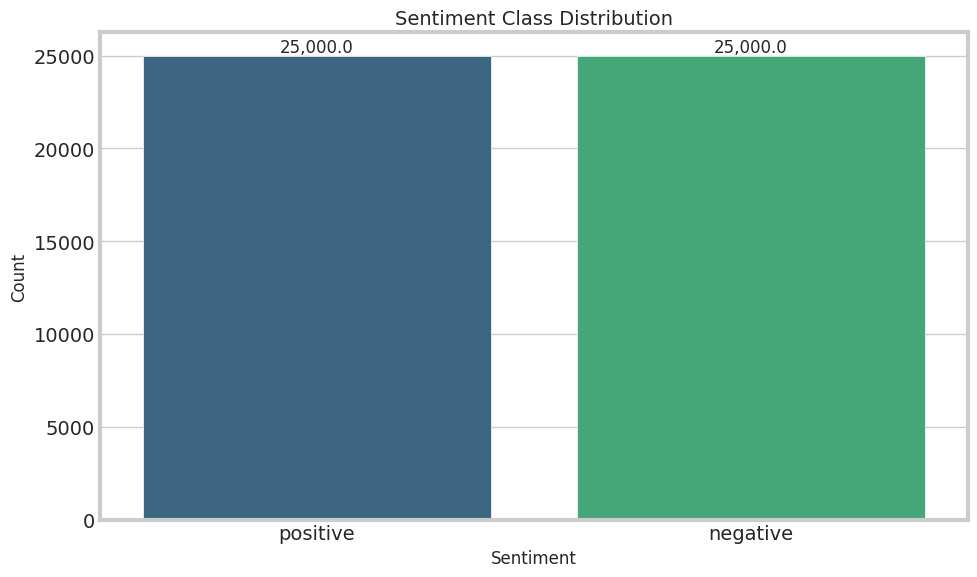

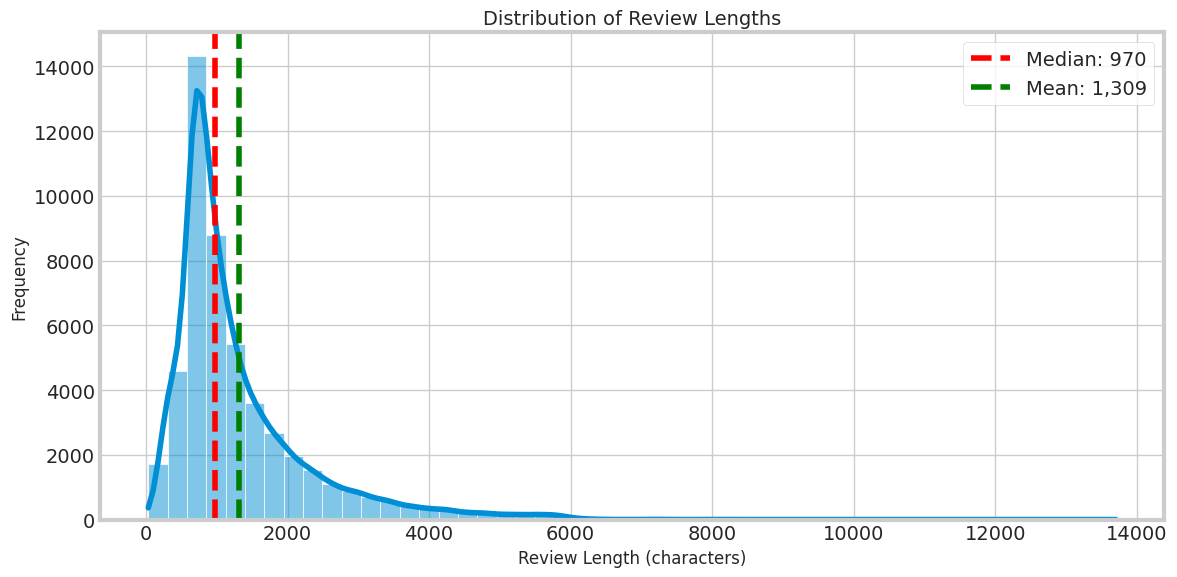

In [4]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(x='sentiment', data=df, palette='viridis')
plt.title('Sentiment Class Distribution', fontsize=14)
plt.xlabel('Sentiment', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{p.get_height():,}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=12)

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='review_length', bins=50, kde=True)
plt.title('Distribution of Review Lengths', fontsize=14)
plt.xlabel('Review Length (characters)', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=df['review_length'].median(), color='red', linestyle='--', label=f'Median: {df["review_length"].median():,.0f}')
plt.axvline(x=df['review_length'].mean(), color='green', linestyle='--', label=f'Mean: {df["review_length"].mean():,.0f}')
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
print("=== SAMPLE REVIEW ANALYSIS ===")
sample_positive = df[df['sentiment'] == 'positive'].iloc[0]
sample_negative = df[df['sentiment'] == 'negative'].iloc[0]

print("\nSample Positive Review:")
print("-" * 80)
print(sample_positive['review'][:500] + "...")
print("-" * 80)
print(f"Length: {len(sample_positive['review'])} characters")

print("\nSample Negative Review:")
print("-" * 80)
print(sample_negative['review'][:500] + "...")
print("-" * 80)
print(f"Length: {len(sample_negative['review'])} characters")

=== SAMPLE REVIEW ANALYSIS ===

Sample Positive Review:
--------------------------------------------------------------------------------
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ...
--------------------------------------------------------------------------------
Length: 1761 characters

Sample Negative Review:
--------------------------------------------------------------------------------
Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This 

## Data Preprocessing

In [6]:
print("Applying case normalization...")
df['review_normalized'] = df['review'].apply(lambda x: x.lower())

print("\nCase Normalization Example:")
original_text = df['review'].iloc[0][:100]
normalized_text = df['review_normalized'].iloc[0][:100]
print(f"Original: {original_text}...")
print(f"Normalized: {normalized_text}...")

Applying case normalization...

Case Normalization Example:
Original: One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. The...
Normalized: one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. the...


In [7]:
print("\nPunctuation characters to remove:")
print(punctuation)

print("\nApplying punctuation removal...")
df['clean_text'] = df['review_normalized'].apply(lambda x: ''.join([c for c in x if c not in punctuation]))

print("\nPunctuation Removal Example:")
normalized_with_punct = df['review_normalized'].iloc[0][:100]
cleaned_text = df['clean_text'].iloc[0][:100]
print(f"Before: {normalized_with_punct}...")
print(f"After: {cleaned_text}...")


Punctuation characters to remove:
!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~

Applying punctuation removal...

Punctuation Removal Example:
Before: one of the other reviewers has mentioned that after watching just 1 oz episode you'll be hooked. the...
After: one of the other reviewers has mentioned that after watching just 1 oz episode youll be hooked they ...


In [8]:
df['clean_text_length'] = df['clean_text'].apply(len)

print("\nPreprocessed Dataset Preview:")
display(df[['sentiment', 'review_length', 'clean_text_length']].head())

length_reduction = (df['review_length'].mean() - df['clean_text_length'].mean()) / df['review_length'].mean() * 100
print(f"\nAverage text length reduction: {length_reduction:.2f}%")

print("\nPreprocessed Dataset Statistics:")
print(f"Total reviews: {len(df)}")
print(f"Average clean text length: {df['clean_text_length'].mean():.2f} characters")
print(f"Median clean text length: {df['clean_text_length'].median():.2f} characters")


Preprocessed Dataset Preview:


,sentiment,review_length,clean_text_length
0,positive,1761,1683
1,positive,998,954
2,positive,926,886
3,negative,748,706
4,positive,1317,1261



Average text length reduction: 4.02%

Preprocessed Dataset Statistics:
Total reviews: 50000
Average clean text length: 1256.85 characters
Median clean text length: 931.00 characters


## Text Tokenization and Encoding

In [9]:
print("Creating corpus for vocabulary construction...")
all_text = ' '.join(df['clean_text'].tolist())

words = all_text.split()
print(f"Total words in corpus: {len(words):,}")

print("\nCalculating word frequencies...")
word_counts = Counter(words)
total_unique_words = len(word_counts)
print(f"Total unique words (vocabulary size): {total_unique_words:,}")

print("\nMost common words in vocabulary:")
for word, count in word_counts.most_common(10):
    print(f"  {word}: {count:,} occurrences")

print("\nLeast common words in vocabulary:")
for word, count in word_counts.most_common()[:-11:-1]:
    print(f"  {word}: {count} occurrences")

Creating corpus for vocabulary construction...
Total words in corpus: 11,512,912

Calculating word frequencies...
Total unique words (vocabulary size): 181,685

Most common words in vocabulary:
  the: 663,815 occurrences
  and: 320,663 occurrences
  a: 320,517 occurrences
  of: 288,382 occurrences
  to: 266,773 occurrences
  is: 210,161 occurrences
  in: 184,861 occurrences
  it: 152,899 occurrences
  i: 152,092 occurrences
  this: 149,405 occurrences

Least common words in vocabulary:
  yosemitebr: 1 occurrences
  studentsthe: 1 occurrences
  horriblecatwoman: 1 occurrences
  clatter: 1 occurrences
  frenchonly: 1 occurrences
  philandererbr: 1 occurrences
  effortful: 1 occurrences
  ohsohard: 1 occurrences
  ashknenazi: 1 occurrences
  jossi: 1 occurrences


In [10]:
print("\nCreating word-to-index mapping...")

sorted_words = word_counts.most_common(total_unique_words)

vocab_to_int = {word: idx+1 for idx, (word, _) in enumerate(sorted_words)}

print(f"Vocabulary created with {len(vocab_to_int):,} words")
print(f"Index range: 1 to {len(vocab_to_int):,}")
print("Index 0 reserved for padding")

print("\nVocabulary sample (word: index):")
sample_items = list(vocab_to_int.items())[:10]
for word, index in sample_items:
    print(f"  {word}: {index}")


Creating word-to-index mapping...
Vocabulary created with 181,685 words
Index range: 1 to 181,685
Index 0 reserved for padding

Vocabulary sample (word: index):
  the: 1
  and: 2
  a: 3
  of: 4
  to: 5
  is: 6
  in: 7
  it: 8
  i: 9
  this: 10


In [11]:
reviews_split = df['clean_text'].tolist()

print("Encoding reviews as integer sequences...")
reviews_encoded = []

for review in reviews_split:
    encoded_review = [vocab_to_int[word] for word in review.split() if word in vocab_to_int]
    reviews_encoded.append(encoded_review)

print("\nExample of encoded reviews:")
print(f"Original text: {reviews_split[0][:50]}...")
print(f"Encoded sequence: {reviews_encoded[0][:20]}...")

review_lengths = [len(review) for review in reviews_encoded]
print(f"\nEncoded review statistics:")
print(f"  Minimum length: {min(review_lengths)} tokens")
print(f"  Maximum length: {max(review_lengths)} tokens")
print(f"  Average length: {np.mean(review_lengths):.2f} tokens")
print(f"  Median length: {np.median(review_lengths):.2f} tokens")

Encoding reviews as integer sequences...

Example of encoded reviews:
Original text: one of the other reviewers has mentioned that afte...
Encoded sequence: [28, 4, 1, 77, 1941, 44, 1063, 11, 100, 145, 40, 479, 3324, 393, 461, 26, 3190, 34, 23, 205]...

Encoded review statistics:
  Minimum length: 4 tokens
  Maximum length: 2469 tokens
  Average length: 230.26 tokens
  Median length: 172.00 tokens


In [12]:
print("\nEncoding sentiment labels...")
sentiment_categories = df['sentiment'].tolist()

encoded_labels = np.array([1 if label == 'positive' else 0 for label in sentiment_categories])

print(f"Label encoding completed: {len(encoded_labels)} labels")
print(f"Class distribution after encoding:")
print(f"  Positive (1): {np.sum(encoded_labels)} ({np.mean(encoded_labels)*100:.1f}%)")
print(f"  Negative (0): {len(encoded_labels) - np.sum(encoded_labels)} ({(1-np.mean(encoded_labels))*100:.1f}%)")


Encoding sentiment labels...
Label encoding completed: 50000 labels
Class distribution after encoding:
  Positive (1): 25000 (50.0%)
  Negative (0): 25000 (50.0%)


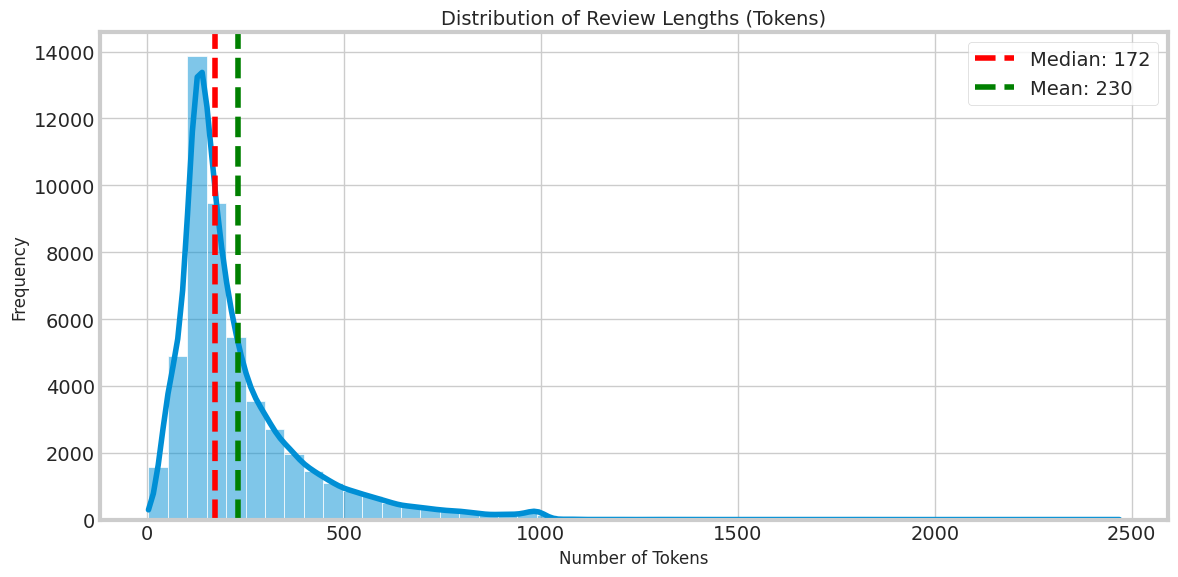


Number of extremely short reviews (<10 tokens): 5
Sample of short reviews:
  Original: More suspenseful, more subtle, much, much more disturbing.......
  Encoded: [51, 2419, 51, 1255, 72, 72, 51, 1216]
  Length: 8 tokens
----------------------------------------
  Original: Read the book, forget the movie!...
  Encoded: [326, 1, 277, 819, 1, 17]
  Length: 6 tokens
----------------------------------------
  Original: Primary plot!Primary direction!Poor interpretation....
  Encoded: [4075, 139486, 139487, 2903]
  Length: 4 tokens
----------------------------------------


In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(review_lengths, bins=50, kde=True)
plt.title('Distribution of Review Lengths (Tokens)', fontsize=14)
plt.xlabel('Number of Tokens', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.axvline(x=np.median(review_lengths), color='red', linestyle='--',
            label=f'Median: {np.median(review_lengths):.0f}')
plt.axvline(x=np.mean(review_lengths), color='green', linestyle='--',
            label=f'Mean: {np.mean(review_lengths):.0f}')
plt.legend()
plt.tight_layout()
plt.show()

short_reviews = [i for i, length in enumerate(review_lengths) if length < 10]
print(f"\nNumber of extremely short reviews (<10 tokens): {len(short_reviews)}")

if short_reviews:
    print("Sample of short reviews:")
    for idx in short_reviews[:3]:
        print(f"  Original: {df['review'].iloc[idx][:100]}...")
        print(f"  Encoded: {reviews_encoded[idx]}")
        print(f"  Length: {len(reviews_encoded[idx])} tokens")
        print("-" * 40)

## Dataset Preparation for Neural Networks

In [14]:
def pad_features(reviews_int, seq_length):
    features = np.zeros((len(reviews_int), seq_length), dtype=int)

    for i, review in enumerate(reviews_int):
        review_len = len(review)

        if review_len <= seq_length:
            zeros = list(np.zeros(seq_length - review_len, dtype=int))
            new_sequence = zeros + review

        else:
            new_sequence = review[-seq_length:]

        features[i, :] = np.array(new_sequence)

    return features

seq_length = 200

print(f"Standardizing sequences to length: {seq_length}")
padded_features = pad_features(reviews_encoded, seq_length)

print(f"\nStandardized sequence shape: {padded_features.shape}")
print(f"  Number of sequences: {padded_features.shape[0]}")
print(f"  Sequence length: {padded_features.shape[1]} tokens")

print("\nExample of standardized sequences:")
print("Short review (padded):")
short_idx = np.argmin([len(r) for r in reviews_encoded])
print(f"  Original length: {len(reviews_encoded[short_idx])} tokens")
print(f"  Padded sequence: {padded_features[short_idx, :20]} ... (zeros are padding)")

print("\nLong review (truncated):")
long_idx = np.argmax([len(r) for r in reviews_encoded])
print(f"  Original length: {len(reviews_encoded[long_idx])} tokens")
print(f"  Truncated sequence: {padded_features[long_idx, :20]} ...")

Standardizing sequences to length: 200

Standardized sequence shape: (50000, 200)
  Number of sequences: 50000
  Sequence length: 200 tokens

Example of standardized sequences:
Short review (padded):
  Original length: 4 tokens
  Padded sequence: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ... (zeros are padding)

Long review (truncated):
  Original length: 2469 tokens
  Truncated sequence: [ 356  131  814  183   24 5248   56 2798  742    5 7918  802   18   27
   99 4215   45    1  802  183] ...


In [15]:
print("Partitioning dataset into training, validation, and testing sets...")

total_samples = len(padded_features)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_end = int(train_ratio * total_samples)
val_end = train_end + int(val_ratio * total_samples)

X_train = padded_features[:train_end]
X_val = padded_features[train_end:val_end]
X_test = padded_features[val_end:]

y_train = encoded_labels[:train_end]
y_val = encoded_labels[train_end:val_end]
y_test = encoded_labels[val_end:]

print("\nDataset Partitioning Results:")
print(f"  Total samples: {total_samples}")
print(f"  Training set: {len(X_train)} samples ({len(X_train)/total_samples*100:.1f}%)")
print(f"  Validation set: {len(X_val)} samples ({len(X_val)/total_samples*100:.1f}%)")
print(f"  Test set: {len(X_test)} samples ({len(X_test)/total_samples*100:.1f}%)")

print("\nClass Distribution Across Splits:")
print(f"  Full dataset: {np.mean(encoded_labels)*100:.1f}% positive")
print(f"  Training set: {np.mean(y_train)*100:.1f}% positive")
print(f"  Validation set: {np.mean(y_val)*100:.1f}% positive")
print(f"  Test set: {np.mean(y_test)*100:.1f}% positive")

Partitioning dataset into training, validation, and testing sets...

Dataset Partitioning Results:
  Total samples: 50000
  Training set: 40000 samples (80.0%)
  Validation set: 5000 samples (10.0%)
  Test set: 5000 samples (10.0%)

Class Distribution Across Splits:
  Full dataset: 50.0% positive
  Training set: 50.0% positive
  Validation set: 50.7% positive
  Test set: 49.4% positive


In [16]:
print("Creating PyTorch datasets and dataloaders...")

train_data = TensorDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
val_data = TensorDataset(torch.from_numpy(X_val), torch.from_numpy(y_val))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))

batch_size = 50

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("\nDataLoader Configuration:")
print(f"  Batch size: {batch_size}")
print(f"  Training batches: {len(train_loader)}")
print(f"  Validation batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

print("\nSample batch inspection:")
sample_x, sample_y = next(iter(train_loader))
print(f"  Input batch shape: {sample_x.shape}")
print(f"  Label batch shape: {sample_y.shape}")
print(f"  Sample input: {sample_x[0, :20]}")
print(f"  Sample label: {sample_y[0].item()}")

Creating PyTorch datasets and dataloaders...

DataLoader Configuration:
  Batch size: 50
  Training batches: 800
  Validation batches: 100
  Test batches: 100

Sample batch inspection:
  Input batch shape: torch.Size([50, 200])
  Label batch shape: torch.Size([50])
  Sample input: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  Sample label: 0


## Model Architecture Design

In [17]:
class SentimentRNN(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()

        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_dim, n_layers,
                          dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        rnn_out, hidden = self.rnn(embeds, hidden)
        rnn_out = rnn_out.contiguous().view(-1, self.hidden_dim)
        out = self.dropout(rnn_out)
        out = self.fc(out)
        sig_out = self.sigmoid(out)
        sig_out = sig_out.view(batch_size, -1)
        return sig_out[:, -1], hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        if torch.cuda.is_available():
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
        else:
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

        return hidden

print("Initializing RNN model architecture...")

vocab_size = len(vocab_to_int) + 1
output_size = 1
embedding_dim = 400
hidden_dim = 256
n_layers = 2

rnn_model = SentimentRNN(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(rnn_model)
print(f"\nModel Parameters:")
total_params = sum(p.numel() for p in rnn_model.parameters())
trainable_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

model_size_mb = sum(p.numel() * p.element_size() for p in rnn_model.parameters()) / (1024 * 1024)
print(f"  Approximate model size: {model_size_mb:.2f} MB")

Initializing RNN model architecture...
SentimentRNN(
  (embedding): Embedding(181686, 400)
  (rnn): RNN(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Model Parameters:
  Total parameters: 72,974,689
  Trainable parameters: 72,974,689
  Approximate model size: 278.38 MB


In [18]:
class SentimentLSTM(nn.Module):
    def __init__(self, vocab_size, output_size, embedding_dim, hidden_dim, n_layers, drop_prob=0.5):
        super().__init__()
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers,
                           dropout=drop_prob, batch_first=True)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_dim, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, hidden):
        batch_size = x.size(0)
        embeds = self.embedding(x)
        lstm_out, hidden = self.lstm(embeds, hidden)
        lstm_out = lstm_out[:, -1, :]
        out = self.dropout(lstm_out)
        out = self.fc(out)
        sig_out = self.sigmoid(out)
        return sig_out, hidden

    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data

        if torch.cuda.is_available():
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
            cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().cuda()
        else:
            hidden = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()
            cell = weight.new(self.n_layers, batch_size, self.hidden_dim).zero_()

        return (hidden, cell)

print("Initializing LSTM model architecture...")

lstm_model = SentimentLSTM(vocab_size, output_size, embedding_dim, hidden_dim, n_layers)

print(lstm_model)
print(f"\nModel Parameters:")
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")

model_size_mb = sum(p.numel() * p.element_size() for p in lstm_model.parameters()) / (1024 * 1024)
print(f"  Approximate model size: {model_size_mb:.2f} MB")

rnn_params = sum(p.numel() for p in rnn_model.parameters())
lstm_params = sum(p.numel() for p in lstm_model.parameters())
print(f"\nModel Comparison:")
print(f"  RNN parameters: {rnn_params:,}")
print(f"  LSTM parameters: {lstm_params:,}")
print(f"  LSTM has {lstm_params - rnn_params:,} more parameters than RNN")

Initializing LSTM model architecture...
SentimentLSTM(
  (embedding): Embedding(181686, 400)
  (lstm): LSTM(400, 256, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Model Parameters:
  Total parameters: 73,874,785
  Trainable parameters: 73,874,785
  Approximate model size: 281.81 MB

Model Comparison:
  RNN parameters: 72,974,689
  LSTM parameters: 73,874,785
  LSTM has 900,096 more parameters than RNN


## Training Configuration

In [19]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on: {device}")

rnn_model = rnn_model.to(device)
lstm_model = lstm_model.to(device)

batch_size = 50
learning_rate = 0.001
epochs = 5
clip = 5
print_every = 100

criterion = nn.BCELoss()

rnn_optimizer = torch.optim.Adam(rnn_model.parameters(), lr=learning_rate)
lstm_optimizer = torch.optim.Adam(lstm_model.parameters(), lr=learning_rate)

rnn_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    rnn_optimizer, mode='min', factor=0.5, patience=1)
lstm_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    lstm_optimizer, mode='min', factor=0.5, patience=1)

patience = 3
min_delta = 0.001

train_loss_history = {'rnn': [], 'lstm': []}
val_loss_history = {'rnn': [], 'lstm': []}
val_accuracy_history = {'rnn': [], 'lstm': []}
best_val_loss = {'rnn': float('inf'), 'lstm': float('inf')}
patience_counter = {'rnn': 0, 'lstm': 0}

print("\n--- Training Configuration ---")
print(f"Batch Size: {batch_size}")
print(f"Learning Rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Gradient Clipping: {clip}")
print(f"Loss Function: {criterion.__class__.__name__}")
print(f"Optimizer: Adam")
print(f"Early Stopping Patience: {patience}")
print(f"Learning Rate Scheduler: ReduceLROnPlateau")

import os
if not os.path.exists('models'):
    os.makedirs('models')
    print("Created directory 'models/' for saving trained models")

Training on: cuda

--- Training Configuration ---
Batch Size: 50
Learning Rate: 0.001
Epochs: 5
Gradient Clipping: 5
Loss Function: BCELoss
Optimizer: Adam
Early Stopping Patience: 3
Learning Rate Scheduler: ReduceLROnPlateau
Created directory 'models/' for saving trained models


## Model Training and Evaluation



In [20]:
def calculate_metrics(y_pred, y_true, threshold=0.5):
    if isinstance(y_pred, torch.Tensor):
        y_pred = y_pred.cpu().detach().numpy()
    if isinstance(y_true, torch.Tensor):
        y_true = y_true.cpu().detach().numpy()

    y_pred_binary = (y_pred > threshold).astype(int)
    accuracy = np.mean(y_pred_binary == y_true)
    tp = np.sum((y_pred_binary == 1) & (y_true == 1))
    fp = np.sum((y_pred_binary == 1) & (y_true == 0))
    fn = np.sum((y_pred_binary == 0) & (y_true == 1))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

In [21]:
def train_epoch(model, train_loader, optimizer, criterion, clip, device, model_type):
    model.train()
    total_loss = 0
    batch_count = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        batch_count += 1
        h = model.init_hidden(batch_size)
        optimizer.zero_grad()
        if device == torch.device("cuda"):
            if model_type == 'rnn':
                h = h.detach()
            else:
                h = tuple([each.detach() for each in h])

        output, h = model(inputs, h)
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        total_loss += loss.item()
        if batch_count % print_every == 0:
            print(f"  Batch {batch_count}/{len(train_loader)} | Loss: {loss.item():.4f}")

    return total_loss / len(train_loader)


def validate(model, val_loader, criterion, device, model_type):
    model.eval()
    val_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = model.init_hidden(batch_size)
            output, h = model(inputs, h)
            val_loss += criterion(output.squeeze(), labels.float()).item()
            all_preds.extend(output.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_loss / len(val_loader)
    metrics = calculate_metrics(np.array(all_preds), np.array(all_labels))

    return val_loss, metrics


def test_model(model, test_loader, criterion, device, model_type):
    model.eval()
    test_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
         for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            h = model.init_hidden(batch_size)
            output, h = model(inputs, h)
            test_loss += criterion(output.squeeze(), labels.float()).item()
            all_preds.extend(output.squeeze().cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_loss = test_loss / len(test_loader)
    metrics = calculate_metrics(np.array(all_preds), np.array(all_labels))

    return test_loss, metrics

In [22]:
def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler,
             clip, epochs, device, model_type):

    train_losses = []
    val_losses = []
    val_metrics = []
    best_val_loss = float('inf')
    patience_counter = 0

    start_time = time.time()

    print(f"\n=== Training {model_type.upper()} Model ===")

    for epoch in range(1, epochs + 1):
        epoch_start = time.time()
        train_loss = train_epoch(model, train_loader, optimizer, criterion, clip, device, model_type)
        train_losses.append(train_loss)
        val_loss, metrics = validate(model, val_loader, criterion, device, model_type)
        val_losses.append(val_loss)
        val_metrics.append(metrics)
        scheduler.step(val_loss)
        epoch_duration = time.time() - epoch_start

        print(f"Epoch {epoch}/{epochs} | Time: {epoch_duration:.2f}s")
        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss: {val_loss:.4f} | Val Accuracy: {metrics['accuracy']:.4f}")
        print(f"  Val Precision: {metrics['precision']:.4f} | Val Recall: {metrics['recall']:.4f} | Val F1: {metrics['f1_score']:.4f}")

        if val_loss < best_val_loss - min_delta:
            print(f"  Validation loss improved from {best_val_loss:.4f} to {val_loss:.4f}")
            best_val_loss = val_loss
            patience_counter = 0

            torch.save(model.state_dict(), f'models/{model_type}_best.pt')
            print(f"  Saved best model to models/{model_type}_best.pt")
        else:
            patience_counter += 1
            print(f"  Validation loss did not improve. Patience: {patience_counter}/{patience}")

            if patience_counter >= patience:
                print(f"  Early stopping triggered after {epoch} epochs")
                break

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time:.2f} seconds")

    return {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'val_metrics': val_metrics,
        'best_val_loss': best_val_loss,
        'training_time': total_time
    }

import time

print("\n" + "="*50)
print("BEGINNING RNN TRAINING")
print("="*50)
rnn_history = train_model(
    model=rnn_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=rnn_optimizer,
    criterion=criterion,
    scheduler=rnn_scheduler,
    clip=clip,
    epochs=epochs,
    device=device,
    model_type='rnn'
)

print("\n" + "="*50)
print("BEGINNING LSTM TRAINING")
print("="*50)
lstm_history = train_model(
    model=lstm_model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=lstm_optimizer,
    criterion=criterion,
    scheduler=lstm_scheduler,
    clip=clip,
    epochs=epochs,
    device=device,
    model_type='lstm'
)


BEGINNING RNN TRAINING

=== Training RNN Model ===
  Batch 100/800 | Loss: 0.6852
  Batch 200/800 | Loss: 0.6870
  Batch 300/800 | Loss: 0.5700
  Batch 400/800 | Loss: 0.6735
  Batch 500/800 | Loss: 0.5797
  Batch 600/800 | Loss: 0.6480
  Batch 700/800 | Loss: 0.6860
  Batch 800/800 | Loss: 0.6038
Epoch 1/5 | Time: 32.10s
  Train Loss: 0.6474
  Val Loss: 0.6257 | Val Accuracy: 0.6564
  Val Precision: 0.6286 | Val Recall: 0.7891 | Val F1: 0.6998
  Validation loss improved from inf to 0.6257
  Saved best model to models/rnn_best.pt
  Batch 100/800 | Loss: 0.5760
  Batch 200/800 | Loss: 0.5348
  Batch 300/800 | Loss: 0.4590
  Batch 400/800 | Loss: 0.6525
  Batch 500/800 | Loss: 0.4492
  Batch 600/800 | Loss: 0.4802
  Batch 700/800 | Loss: 0.4737
  Batch 800/800 | Loss: 0.5515
Epoch 2/5 | Time: 32.07s
  Train Loss: 0.5548
  Val Loss: 0.5620 | Val Accuracy: 0.7204
  Val Precision: 0.6996 | Val Recall: 0.7868 | Val F1: 0.7406
  Validation loss improved from 0.6257 to 0.5620
  Saved best mod

In [23]:
rnn_model.load_state_dict(torch.load('models/rnn_best.pt'))
lstm_model.load_state_dict(torch.load('models/lstm_best.pt'))

print("\n--- Evaluating Models on Test Set ---")

print("\nRNN Model Performance:")
rnn_test_loss, rnn_metrics = test_model(rnn_model, test_loader, criterion, device, 'rnn')
print(f"Test Loss: {rnn_test_loss:.4f}")
print(f"Test Accuracy: {rnn_metrics['accuracy']:.4f}")
print(f"Test Precision: {rnn_metrics['precision']:.4f}")
print(f"Test Recall: {rnn_metrics['recall']:.4f}")
print(f"Test F1-Score: {rnn_metrics['f1_score']:.4f}")

print("\nLSTM Model Performance:")
lstm_test_loss, lstm_metrics = test_model(lstm_model, test_loader, criterion, device, 'lstm')
print(f"Test Loss: {lstm_test_loss:.4f}")
print(f"Test Accuracy: {lstm_metrics['accuracy']:.4f}")
print(f"Test Precision: {lstm_metrics['precision']:.4f}")
print(f"Test Recall: {lstm_metrics['recall']:.4f}")
print(f"Test F1-Score: {lstm_metrics['f1_score']:.4f}")

print("\n--- Model Comparison ---")
print(f"{'Metric':<15} {'RNN':<15} {'LSTM':<15} {'Difference':<15}")
print("-" * 60)
print(f"{'Test Loss':<15} {rnn_test_loss:<15.4f} {lstm_test_loss:<15.4f} {lstm_test_loss - rnn_test_loss:<15.4f}")
print(f"{'Accuracy':<15} {rnn_metrics['accuracy']:<15.4f} {lstm_metrics['accuracy']:<15.4f} {lstm_metrics['accuracy'] - rnn_metrics['accuracy']:<15.4f}")
print(f"{'Precision':<15} {rnn_metrics['precision']:<15.4f} {lstm_metrics['precision']:<15.4f} {lstm_metrics['precision'] - rnn_metrics['precision']:<15.4f}")
print(f"{'Recall':<15} {rnn_metrics['recall']:<15.4f} {lstm_metrics['recall']:<15.4f} {lstm_metrics['recall'] - rnn_metrics['recall']:<15.4f}")
print(f"{'F1-Score':<15} {rnn_metrics['f1_score']:<15.4f} {lstm_metrics['f1_score']:<15.4f} {lstm_metrics['f1_score'] - rnn_metrics['f1_score']:<15.4f}")
print(f"{'Training Time':<15} {rnn_history['training_time']:<15.2f} {lstm_history['training_time']:<15.2f} {lstm_history['training_time'] - rnn_history['training_time']:<15.2f}")

if rnn_metrics['accuracy'] > 0:
    accuracy_improvement = ((lstm_metrics['accuracy'] - rnn_metrics['accuracy']) / rnn_metrics['accuracy']) * 100
    print(f"\nLSTM accuracy improvement over RNN: {accuracy_improvement:.2f}%")

if rnn_history['training_time'] > 0:
    time_difference = ((lstm_history['training_time'] - rnn_history['training_time']) / rnn_history['training_time']) * 100
    if time_difference > 0:
        print(f"LSTM training was {time_difference:.2f}% slower than RNN")
    else:
        print(f"LSTM training was {abs(time_difference):.2f}% faster than RNN")


--- Evaluating Models on Test Set ---

RNN Model Performance:
Test Loss: 0.4930
Test Accuracy: 0.7778
Test Precision: 0.7475
Test Recall: 0.8308
Test F1-Score: 0.7870

LSTM Model Performance:
Test Loss: 0.2736
Test Accuracy: 0.8922
Test Precision: 0.8764
Test Recall: 0.9101
Test F1-Score: 0.8929

--- Model Comparison ---
Metric          RNN             LSTM            Difference     
------------------------------------------------------------
Test Loss       0.4930          0.2736          -0.2194        
Accuracy        0.7778          0.8922          0.1144         
Precision       0.7475          0.8764          0.1289         
Recall          0.8308          0.9101          0.0794         
F1-Score        0.7870          0.8929          0.1060         
Training Time   174.09          263.80          89.71          

LSTM accuracy improvement over RNN: 14.71%
LSTM training was 51.53% slower than RNN


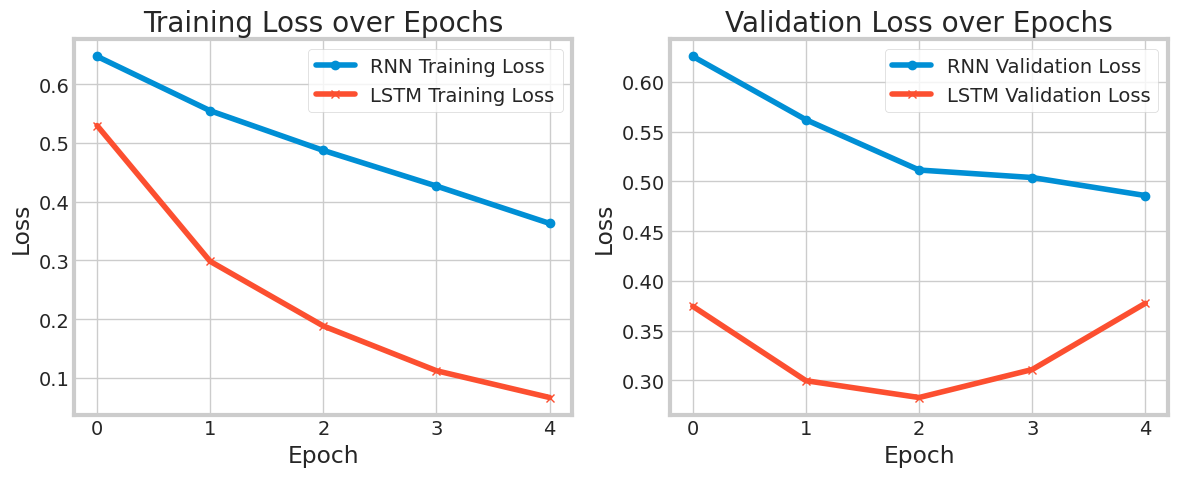

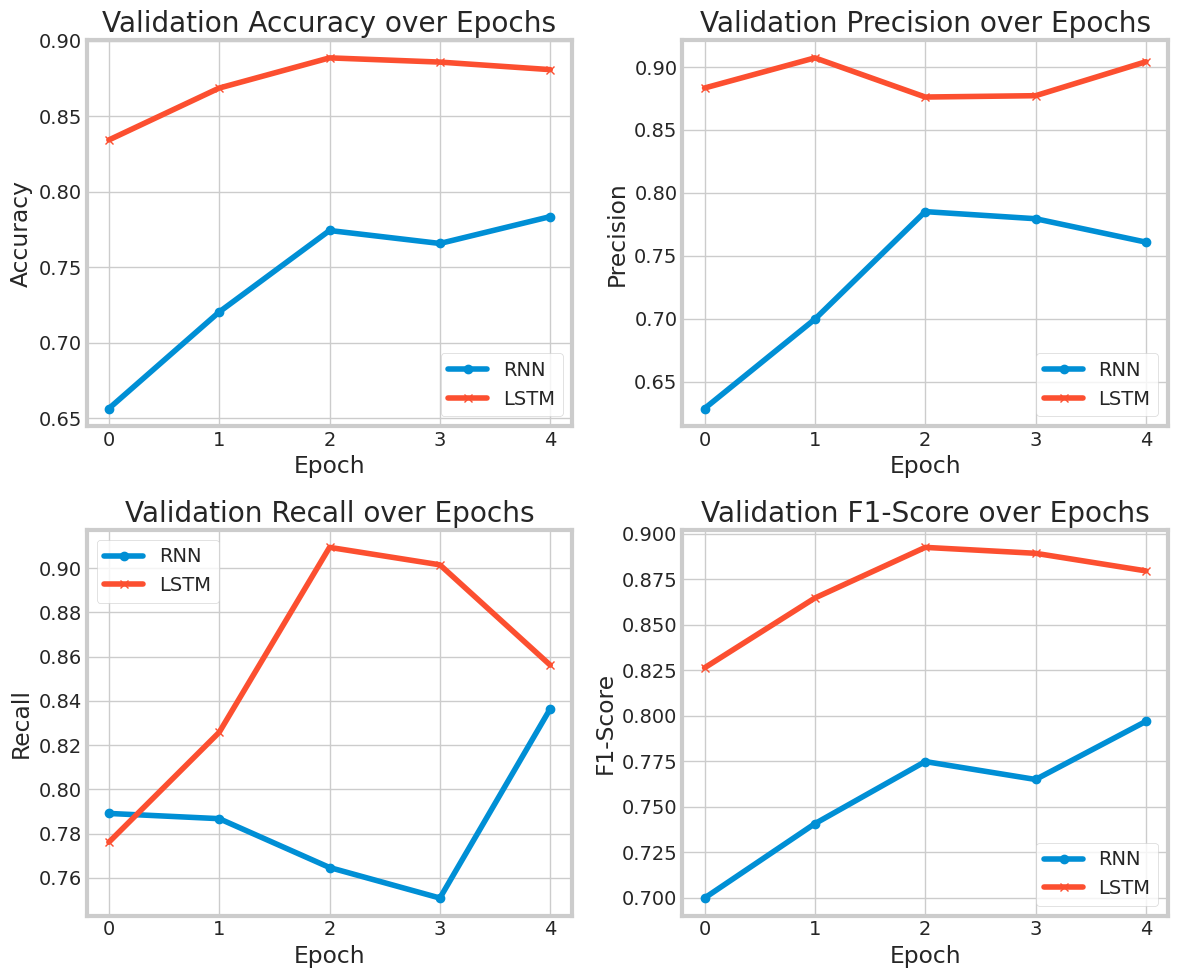

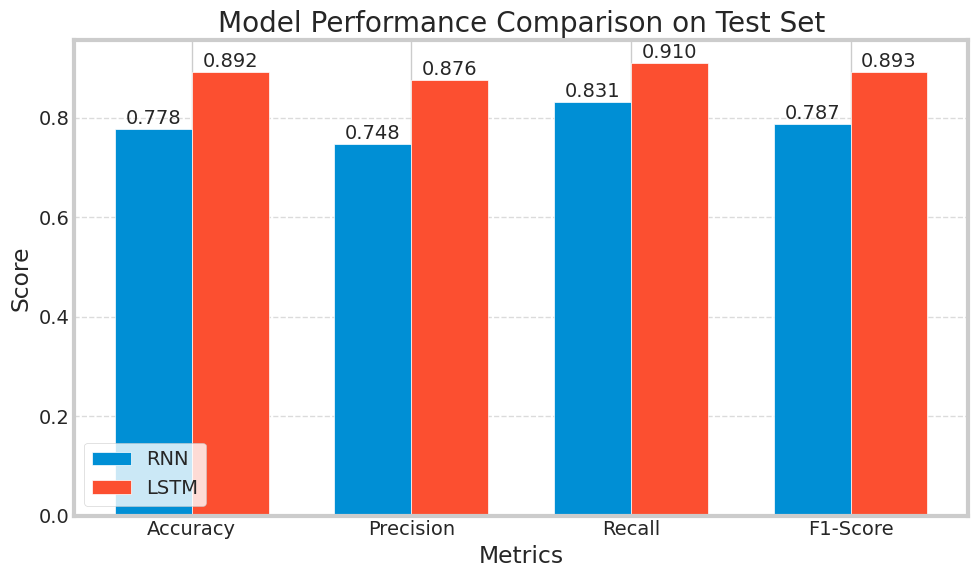

In [24]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(rnn_history['train_losses'], label='RNN Training Loss', marker='o')
plt.plot(lstm_history['train_losses'], label='LSTM Training Loss', marker='x')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(rnn_history['val_losses'], label='RNN Validation Loss', marker='o')
plt.plot(lstm_history['val_losses'], label='LSTM Validation Loss', marker='x')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

rnn_val_accuracy = [m['accuracy'] for m in rnn_history['val_metrics']]
lstm_val_accuracy = [m['accuracy'] for m in lstm_history['val_metrics']]

plt.figure(figsize=(12, 10))

plt.subplot(2, 2, 1)
plt.plot(rnn_val_accuracy, label='RNN', marker='o')
plt.plot(lstm_val_accuracy, label='LSTM', marker='x')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot([m['precision'] for m in rnn_history['val_metrics']], label='RNN', marker='o')
plt.plot([m['precision'] for m in lstm_history['val_metrics']], label='LSTM', marker='x')
plt.title('Validation Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot([m['recall'] for m in rnn_history['val_metrics']], label='RNN', marker='o')
plt.plot([m['recall'] for m in lstm_history['val_metrics']], label='LSTM', marker='x')
plt.title('Validation Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot([m['f1_score'] for m in rnn_history['val_metrics']], label='RNN', marker='o')
plt.plot([m['f1_score'] for m in lstm_history['val_metrics']], label='LSTM', marker='x')
plt.title('Validation F1-Score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
rnn_values = [rnn_metrics['accuracy'], rnn_metrics['precision'],
              rnn_metrics['recall'], rnn_metrics['f1_score']]
lstm_values = [lstm_metrics['accuracy'], lstm_metrics['precision'],
               lstm_metrics['recall'], lstm_metrics['f1_score']]

plt.figure(figsize=(10, 6))
x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width/2, rnn_values, width, label='RNN')
plt.bar(x + width/2, lstm_values, width, label='LSTM')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Performance Comparison on Test Set')
plt.xticks(x, metrics)
plt.legend()
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

for i, v in enumerate(rnn_values):
    plt.text(i - width/2, v + 0.01, f'{v:.3f}', ha='center')

for i, v in enumerate(lstm_values):
    plt.text(i + width/2, v + 0.01, f'{v:.3f}', ha='center')

plt.tight_layout()
plt.show()

## Model Inference with User Input


In [25]:
def predict_sentiment(model, review_text, device, sequence_length=200):
    model.eval()

    review_text = review_text.lower()
    review_text = ''.join([c for c in review_text if c not in punctuation])
    words = review_text.split()
    word_indices = []
    for word in words:
        if word in vocab_to_int:
            word_indices.append(vocab_to_int[word])
        else:
            word_indices.append(0)

    if len(word_indices) > sequence_length:
        word_indices = word_indices[-sequence_length:]
    else:
        zeros = [0] * (sequence_length - len(word_indices))
        word_indices = zeros + word_indices

    inputs = torch.tensor(word_indices).unsqueeze(0).to(device)
    h = model.init_hidden(1)
    if device == torch.device("cuda"):
        if isinstance(h, tuple):
            h = tuple([each.detach().cuda() for each in h])
        else:
            h = h.detach().cuda()

    with torch.no_grad():
        output, _ = model(inputs, h)

    prob = output.item()

    if prob >= 0.5:
        sentiment = 'Positive'
    else:
        sentiment = 'Negative'

    confidence = prob if prob >= 0.5 else 1 - prob
    confidence_pct = confidence * 100

    return sentiment, confidence_pct


def analyze_review(review_text):
    print("\n" + "="*60)
    print(f"Analyzing review: {review_text[:100]}..." if len(review_text) > 100 else f"Analyzing review: {review_text}")
    print("="*60)

    rnn_sentiment, rnn_confidence = predict_sentiment(rnn_model, review_text, device)
    lstm_sentiment, lstm_confidence = predict_sentiment(lstm_model, review_text, device)

    print("\nResults:")
    print(f"RNN Model: {rnn_sentiment} (Confidence: {rnn_confidence:.2f}%)")
    print(f"LSTM Model: {lstm_sentiment} (Confidence: {lstm_confidence:.2f}%)")

    if rnn_sentiment == lstm_sentiment:
        print(f"\nBoth models agree: This review expresses {rnn_sentiment.lower()} sentiment.")
    else:
        print("\nModels disagree on sentiment classification.")
        print(f"RNN predicts {rnn_sentiment.lower()} with {rnn_confidence:.2f}% confidence.")
        print(f"LSTM predicts {lstm_sentiment.lower()} with {lstm_confidence:.2f}% confidence.")
        print("Consider the model with higher confidence or review the text further.")

example_reviews = [
    "This movie was absolutely fantastic! The acting was superb and the plot kept me engaged from start to finish.",
    "I was very disappointed with this film. The characters were poorly developed and the story made no sense at all.",
    "It was an okay movie. Some parts were good but others were boring. Not great, not terrible.",
    "The special effects were amazing but everything else about this movie was terrible."
]

for i, review in enumerate(example_reviews):
    print(f"\nExample {i+1}:")
    analyze_review(review)

print("\n" + "="*60)
print("Enter your own movie review to analyze (or type 'exit' to quit):")
print("="*60)

while True:
    user_input = input("\nEnter a movie review: ")
    if user_input.lower() == 'exit':
        print("Exiting sentiment analysis.")
        break
    if not user_input.strip():
        print("Please enter a review or type 'exit'.")
        continue

    analyze_review(user_input)


Example 1:

Analyzing review: This movie was absolutely fantastic! The acting was superb and the plot kept me engaged from start t...

Results:
RNN Model: Positive (Confidence: 64.29%)
LSTM Model: Positive (Confidence: 98.51%)

Both models agree: This review expresses positive sentiment.

Example 2:

Analyzing review: I was very disappointed with this film. The characters were poorly developed and the story made no s...

Results:
RNN Model: Negative (Confidence: 82.57%)
LSTM Model: Negative (Confidence: 99.72%)

Both models agree: This review expresses negative sentiment.

Example 3:

Analyzing review: It was an okay movie. Some parts were good but others were boring. Not great, not terrible.

Results:
RNN Model: Negative (Confidence: 88.43%)
LSTM Model: Negative (Confidence: 98.86%)

Both models agree: This review expresses negative sentiment.

Example 4:

Analyzing review: The special effects were amazing but everything else about this movie was terrible.

Results:
RNN Model: Negati